### creating, evaluating and predicting next word using MLP (with 3 char context)

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [40]:
# reading dataset etc

# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(words[:8])
print(len(words))

# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
32033
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [41]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size # initial context of each word
    
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(f"{X.shape, Y.shape=}")
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


X.shape, Y.shape=(torch.Size([182625, 3]), torch.Size([182625]))
X.shape, Y.shape=(torch.Size([22655, 3]), torch.Size([22655]))
X.shape, Y.shape=(torch.Size([22866, 3]), torch.Size([22866]))


#### short baby implementation

In [42]:
C = torch.randn((27, 2)) # embedding table from where each character will get it's vector of size 2 (the first layer)
print(C.shape)
print(Xtr.shape)

emb = C[Xtr] # each character is assigned it's embedding vector, using advanced indexing/lookup
print(emb.shape)

torch.Size([27, 2])
torch.Size([182625, 3])
torch.Size([182625, 3, 2])


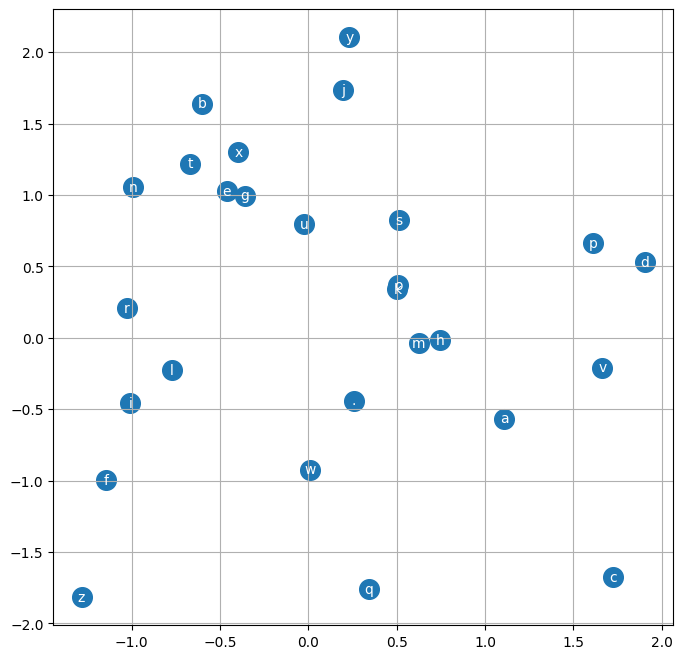

In [43]:
# visualize of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [44]:
W1 = torch.randn((6, 100)) # the second layer
b1 = torch.randn(100)
# print(emb.view(-1, 6).shape) # torch.Size([182580, 6])
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
print(h.shape)

torch.Size([182625, 100])


In [45]:
W2 = torch.randn((100, 27)) # third layer with softmax
b2 = torch.randn(27)

logits = h @ W2 + b2
print(logits.shape)

counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
print(prob.shape)

torch.Size([182625, 27])
torch.Size([182625, 27])


In [46]:
loss = -prob[torch.arange(Ytr.shape[0]), Ytr].log().mean()
loss

tensor(13.8366)

#### .

In [47]:
# defining 3 layers MLP model
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g) # embedding vector size is increased to 10
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

sum(p.nelement() for p in parameters) # number of parameters in total

for p in parameters:
  p.requires_grad = True

completed training percentage: 0.00%, Loss = 2.3086111545562744
completed training percentage: 5.00%, Loss = 2.763122081756592
completed training percentage: 10.00%, Loss = 1.925137996673584
completed training percentage: 15.00%, Loss = 2.0836880207061768
completed training percentage: 20.00%, Loss = 2.456584930419922
completed training percentage: 25.00%, Loss = 2.1973276138305664
completed training percentage: 30.00%, Loss = 2.4130241870880127
completed training percentage: 35.00%, Loss = 2.1387219429016113
completed training percentage: 40.00%, Loss = 2.706620216369629
completed training percentage: 45.00%, Loss = 2.1551477909088135
completed training percentage: 50.00%, Loss = 1.8980756998062134
completed training percentage: 55.00%, Loss = 1.7303822040557861
completed training percentage: 60.00%, Loss = 2.166382312774658
completed training percentage: 65.00%, Loss = 2.149247884750366
completed training percentage: 70.00%, Loss = 1.852949619293213
completed training percentage: 75.

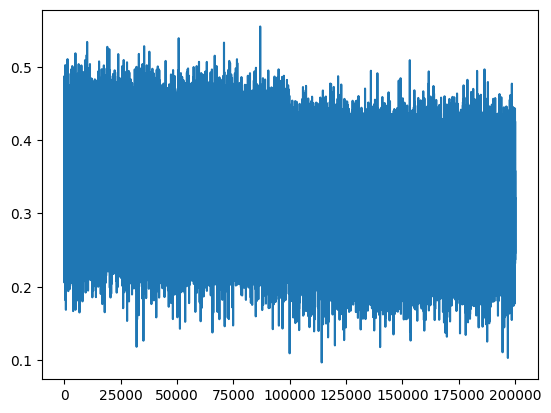

In [51]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

lri = []
lossi = []
stepi = []

epochs = 200000
for i in range(epochs):
  # mini batch construct
  ix = torch.randint(0, Xtr.shape[0], (32,)) # random contiguous sample of 32 examples from the training set
  
  # forward pass
  # layer 1
  emb = C[Xtr[ix]] # (32, 3, 10) i.e every example contains context of length 3
  
  # layer 2
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  
  # layer 3
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix]) # Unnormalized logits (any real numbers), internally it takes softmax and then negative log likelihood loss, and averages over the examples in the mini batch
  if i % 10000 == 0:
    print(f"completed training percentage: {i/epochs*100:.2f}%, Loss = {loss.item()}")
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

# print(loss.item())
plt.plot(stepi, lossi)

In [50]:
# model prediction
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

der.
marosalee.
roszarynn.
lonimittainella.
kaman.
arsemithumphann.
gotas.
mora.
danvora.
predoran.
davanseden.
niavion.
bronse.
hundven.
tahlan.
dashra.
lewglen.
niaivan.
jurzenner.
brayden.
